In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss, log_loss

In [8]:
from util import import_and_shape_data, run_pycox_on_group

interval_and_weather_merged = import_and_shape_data()

# interval_and_weather_merged


(298, 21)
(46, 21)


In [20]:
interval_and_weather_merged['interval'].max()

12655.0

In [4]:

### SIMULATE SURVIVAL DATA ###

def sim_event_times(n_samples=3000, n_features=20, random_state=0):

    X, y = make_regression(
        n_samples=n_samples, n_features=n_features, 
        n_informative=int(n_features*.4), random_state=random_state,
    )
    y = np.searchsorted(np.quantile(y, np.linspace(0,1, 10)), y)
        
    np.random.seed(random_state)
    betas = 365 * np.exp(-0.6 * y) / np.log(1.1)
    y_time = np.random.exponential(betas)
    
    return X, y_time

# X are array of covariates and y_time is the time of "death"
# X, y_time = sim_event_times(n_samples=3000, n_features=20)

y_time = interval_and_weather_merged['interval']
X = interval_and_weather_merged[['same_species', 'temp', 'wspd', 'dwpt', 'coco']]


In [20]:
y_time

0      150.0
1     1170.0
2      660.0
3      124.0
4       31.0
       ...  
41    3121.0
42      90.0
43    4000.0
44     600.0
45     839.0
Name: interval, Length: 292, dtype: float64

In [21]:
## ADJUST EVENT TARGET ###

# Matching number of bins that are used for the regression covariate weight
n_bins = 25
# TODO: Figure out how max_time is effecting it
max_time = 4000

y_time[(y_time > max_time)] = max_time
bin_edges = np.linspace(y_time.min(), y_time.max(), n_bins+1)

bin_edges[0] = 0
print(bin_edges)

encoder = OneHotEncoder(
    categories = [np.arange(n_bins+1)],
    sparse = False, drop = None
).fit(np.zeros((1, 1)))

time = np.searchsorted(bin_edges[1:], y_time, side='right')
y_time_ohe = encoder.transform(time.reshape(-1, 1))
y_time_ohe = np.cumsum(y_time_ohe, 1)
y_time_ohe = y_time_ohe[:,:-1]

y_time_ohe.shape

[   0.    160.96  320.92  480.88  640.84  800.8   960.76 1120.72 1280.68
 1440.64 1600.6  1760.56 1920.52 2080.48 2240.44 2400.4  2560.36 2720.32
 2880.28 3040.24 3200.2  3360.16 3520.12 3680.08 3840.04 4000.  ]


/var/folders/vt/546593w53sx4zw12xsp5qhx00000gp/T/ipykernel_12871/180668223.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_time[(y_time > max_time)] = max_time
/Users/jonah/Personal/Native-Bee-Thesis/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(292, 25)

In [26]:
y_time_ohe[-1]

array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

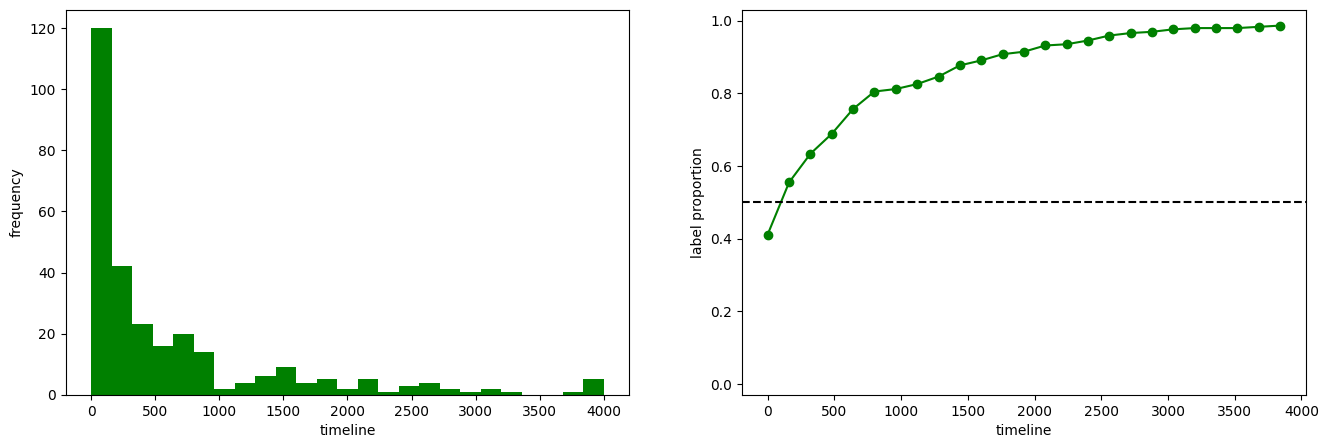

In [13]:
### PLOT EVENT TARGET AND LABEL PROPORTION ###

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.hist(y_time, bins=bin_edges, color='green')
plt.xlabel('timeline'); plt.ylabel('frequency')
plt.subplot(1,2,2)
plt.plot(bin_edges[:-1], y_time_ohe.mean(axis=0), marker='o', color='green')
plt.ylim([-0.03,1.03]); plt.axhline(0.5, linestyle='--', c='black')
plt.xlabel('timeline'); plt.ylabel('label proportion')
plt.show()

In [14]:
### TRAIN-TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(
    X, y_time_ohe, test_size=0.25, shuffle=True, random_state=33
)

y_test = 1 - y_test

In [15]:
### FIT CHAIN CLASSIFIER ###
# A multi-label model that arranges binary classifiers into a chain.
model = ClassifierChain(
    LogisticRegression(random_state=33, max_iter=2000),
    cv=5
)
model.fit(X_train, y_train)

/Users/jonah/Personal/Native-Bee-Thesis/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/jonah/Personal/Native-Bee-Thesis/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/jonah/Personal/Native-Bee-Thesis/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/jonah/Personal/Native-Bee-Thesis/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


ClassifierChain(base_estimator=LogisticRegression(max_iter=2000,
                                                  random_state=33),
                cv=5)

In [17]:
### POST-PROCESSING SURVIVAL CURVE PREDICTIONS ###

isoreg = IsotonicRegression(y_min=0, y_max=1, increasing=True)
x = np.arange(0, n_bins)

proba = model.predict_proba(X_test)

proba = Parallel(n_jobs=-1, verbose=1)(
    delayed(isoreg.fit_transform)(x, p) 
    for p in proba
)
proba = 1 - np.asarray(proba)

proba.shape

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:    2.4s finished


(73, 25)

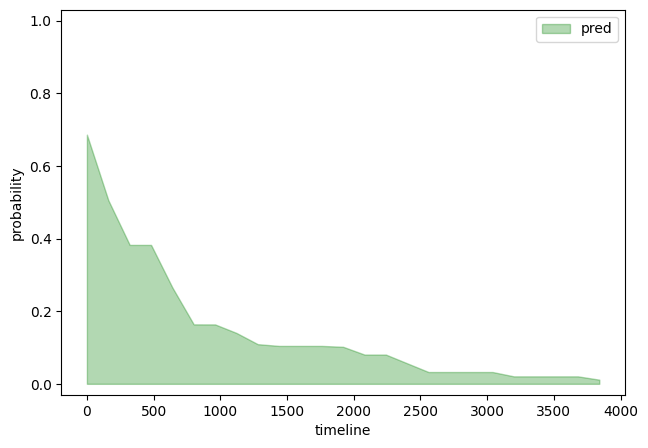

In [18]:
### PLOT PREDICTED SURVIVAL CURVES ###

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.fill_between(bin_edges[:-1], proba[5], color='green', alpha=0.3, label='pred')
# plt.plot(bin_edges[:-1], y_test[5], color='orange', label='true')
plt.ylim([-0.03,1.03])
plt.xlabel('timeline'); plt.ylabel('probability'); plt.legend()

# plt.subplot(1,2,2)
# plt.fill_between(bin_edges[:-1], proba[15], color='green', alpha=0.3, label='pred')
# plt.plot(bin_edges[:-1], y_test[15], color='orange', label='true')
# plt.ylim([-0.03,1.03])
# plt.xlabel('timeline'); plt.ylabel('probability'); plt.legend()
# plt.show()

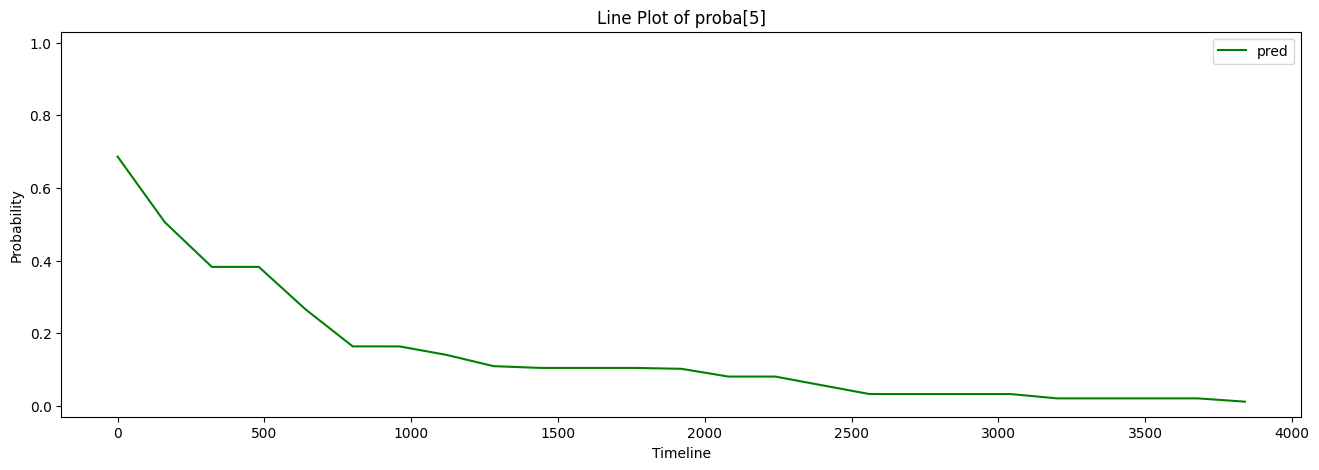

In [31]:
fig, ax = plt.subplots(figsize=(16, 5))

# Plot the line
ax.plot(bin_edges[:-1], proba[5], color='green', label='pred')

# Set the axis labels and title
ax.set_xlabel('Timeline')
ax.set_ylabel('Probability')
ax.set_title('Line Plot of proba[5]')

# Add a legend
ax.legend()

# Adjust the y-axis limits
ax.set_ylim([-0.03, 1.03])

# Show the plot
plt.show()
